# Modelling the behavior of a mass-on-spring system

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, Bidirectional

import random
from random import seed, random
from sklearn.utils import shuffle
from sklearn import preprocessing

%matplotlib inline

/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [97]:
np.random.seed(1337)  # for reproducibility

raw_data = pd.read_csv("data/SpringData.csv", na_filter=False)

# The first 5 rows of the csv
print(raw_data.head(5))

   VideoAnalysis: Time (s)  VideoAnalysis: X  VideoAnalysis: Y  \
0                 0.000000         -1.054688          0.222656   
1                 0.033367         -1.445312        -13.539062   
2                 0.066733         -1.054688        -36.414062   
3                 0.100100          0.375000        -51.472656   
4                 0.133467         -1.750000        -64.359375   

   VideoAnalysis: X Velocity  VideoAnalysis: Y Velocity  
0                  -3.473089                -475.292936  
1                   3.892592                -527.293345  
2                  13.162619                -515.316715  
3                  -1.118673                -407.544929  
4                  -1.908898                -261.291443  


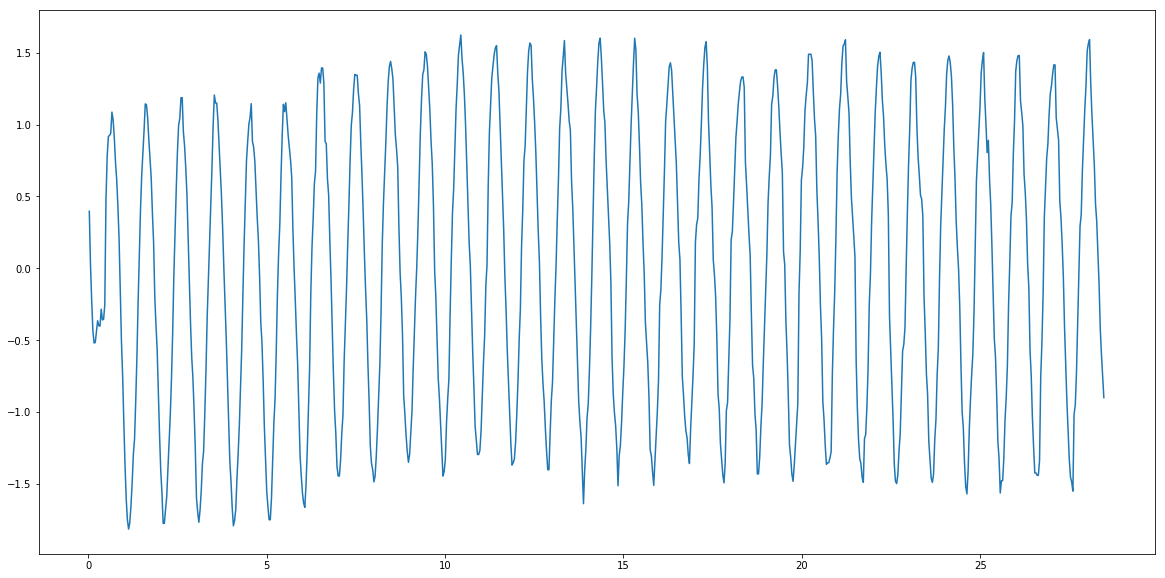

In [141]:
window = 1
edge = int(np.ceil(window/2))

def preprocess(data):
    # Calculate the moving average
    data = data.rolling(window=window,center=True).mean()
    # Trim the data that wasn't part of the moving average
    data = data[edge:-edge]
    # Standardize the data
    return preprocessing.scale(data) 

time = raw_data["VideoAnalysis: Time (s)"][edge:-edge].values
X_data = preprocess(raw_data["VideoAnalysis: X"])
Y_data = preprocess(raw_data["VideoAnalysis: Y"])
data = Y_data

plt.figure(figsize=(20,10))
# plt.plot(x)
plt.plot(time, Y_data)

In [127]:
# hyperparameters
DATA_DIM = 1
N_PREV = 50 # number of previous steps used to predict the next step

In [128]:
def _load_data(data, n_prev=N_PREV, is_shuffled=False):
    docX, docY = [], []
    for j in range(len(data)-n_prev):
        docX.append(data[j:j+n_prev])
        docY.append(data[j+n_prev])   
    alsX = np.array(docX)
    alsY = np.array(docY)
    if is_shuffled: 
        alsX, alsY = shuffle(alsX, alsY)

    return alsX.reshape(alsX.shape[0], alsX.shape[1], DATA_DIM), alsY.reshape(alsY.shape[0], DATA_DIM)

def train_test_split(data, test_size=0.6):  
    """
    This just splits data to training and testing parts
    """
    ntrn = int(round(len(data) * (1 - test_size)))

    X_train, y_train = _load_data(data[0:ntrn], is_shuffled=True)
    X_test, y_test = _load_data(data[ntrn:])

    return (X_train, y_train), (X_test, y_test)


# retrieve data
(X_train, y_train), (X_test, y_test) = train_test_split(data, 0.3)

In [129]:
# define model structure
model = Sequential()
model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=True), input_shape=(None, DATA_DIM)))
model.add(Bidirectional(CuDNNLSTM(units=5, return_sequences=False)))
# model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=True)))
# model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=False)))
model.add(Dense(units=1, activation="linear"))
model.compile(loss="mean_squared_error", optimizer="adam")

In [130]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.1)

Train on 492 samples, validate on 55 samples
Epoch 1/100
492/492 [==============================] - 1s 2ms/step - loss: 0.5808 - val_loss: 0.4198
Epoch 2/100
492/492 [==============================] - 0s 643us/step - loss: 0.3137 - val_loss: 0.2053
Epoch 3/100
492/492 [==============================] - 0s 638us/step - loss: 0.1613 - val_loss: 0.1091
Epoch 4/100
492/492 [==============================] - 0s 635us/step - loss: 0.1060 - val_loss: 0.0919
Epoch 5/100
492/492 [==============================] - 0s 647us/step - loss: 0.0919 - val_loss: 0.0820
Epoch 6/100
492/492 [==============================] - 0s 633us/step - loss: 0.0816 - val_loss: 0.0730
Epoch 7/100
492/492 [==============================] - 0s 629us/step - loss: 0.0743 - val_loss: 0.0652
Epoch 8/100
492/492 [==============================] - 0s 645us/step - loss: 0.0673 - val_loss: 0.0610
Epoch 9/100
492/492 [==============================] - 0s 646us/step - loss: 0.0582 - val_loss: 0.0492
Epoch 10/100
492/492 [========

dict_keys(['val_loss', 'loss'])
100


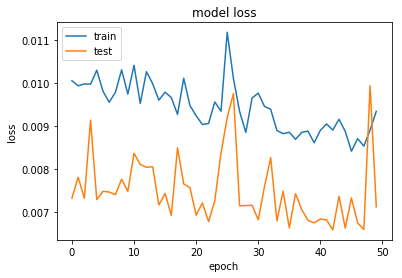

In [203]:
print(history.history.keys())
print(len(history.history['val_loss']))
# summarize history for loss
plt.plot(history.history['loss'][-50:])
plt.plot(history.history['val_loss'][-50:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [140]:
# evaluate model fit
test_prediction = model.predict(X_test)
# score = model.evaluate(X_test, y_test)
# evaluate
print('Test score:', np.mean((test_prediction-y_test)**2))

Test score: 0.012516255141837922


In [178]:
# generate the time axis for visualization
t_step = np.mean(time[1:]-time[:-1])
t_start = time[-len(y_test)]

def gen_time(data):
    t = np.arange(t_start, t_start+len(data)*t_step, t_step)
    return t

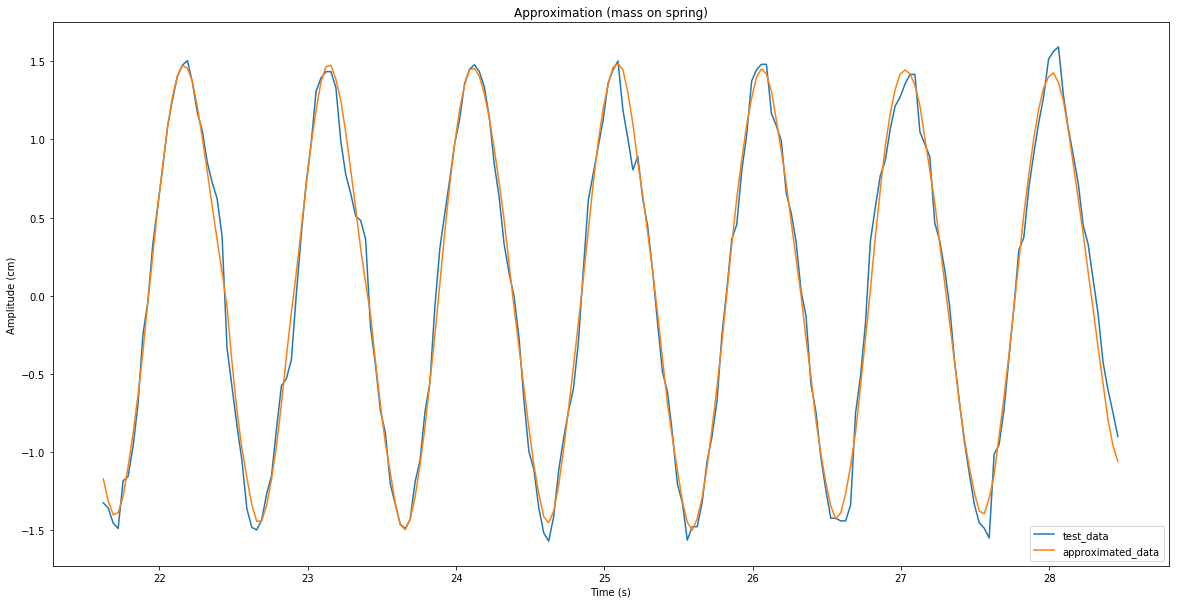

In [207]:
# visualize approximation performance on test data set
t1 = gen_time(y_test)

plt.figure(figsize=(20,10))
plt.plot(t1, y_test[:], label='test_data')
plt.plot(t1, test_prediction[:], label='approximated_data')
plt.title('Approximation (mass on spring)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (cm)')
plt.legend()

In [210]:
# perform modelling
X_model = X_test[0]
modelled_data = []
dims = 1, X_model.shape[0], X_model.shape[1]
for i in range(len(y_test)*2):
    prev_steps = X_model.reshape(*dims)
    next_step = model.predict(prev_steps)
    modelled_data.append(list(next_step[0]))
    X_model = np.append(X_model[1:], next_step)

# evaluate
print('Prediction score:', np.mean((modelled_data[:len(y_test)]-y_test)**2))

Prediction score: 0.01762662168790871


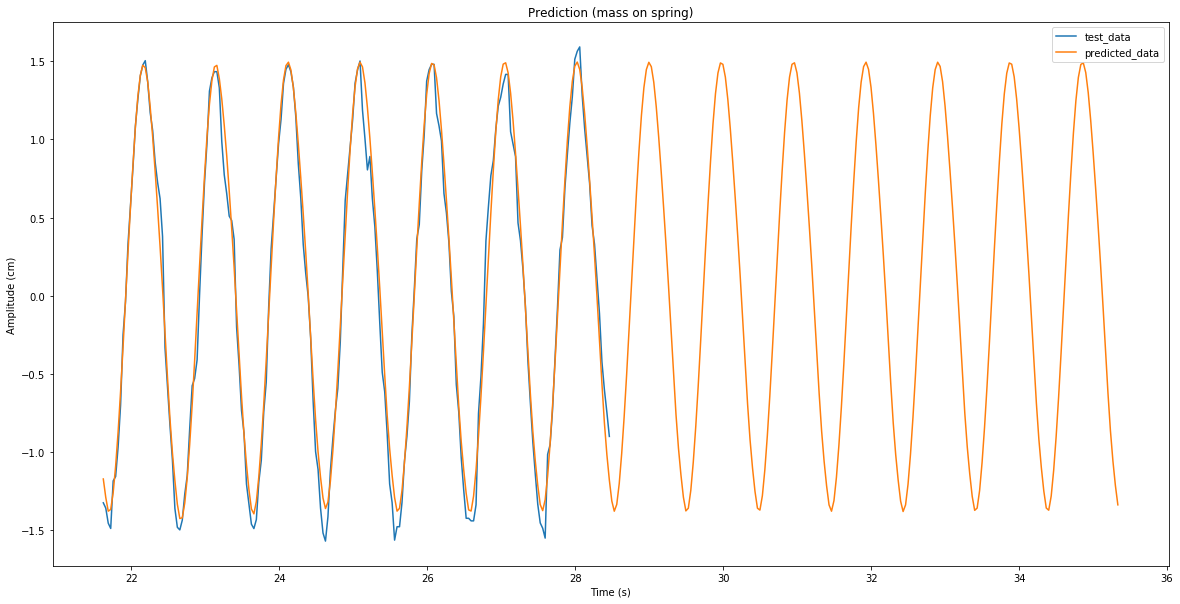

In [211]:
# visualize prediction performance
t2 = gen_time(modelled_data)

plt.figure(figsize=(20,10))
plt.plot(t1, y_test[:], label='test_data')
plt.plot(t2, modelled_data[:], label='predicted_data')
plt.title('Prediction (mass on spring)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (cm)')
plt.legend()

In [201]:
# visualize approximations
train_prediction = model.predict(X_train)

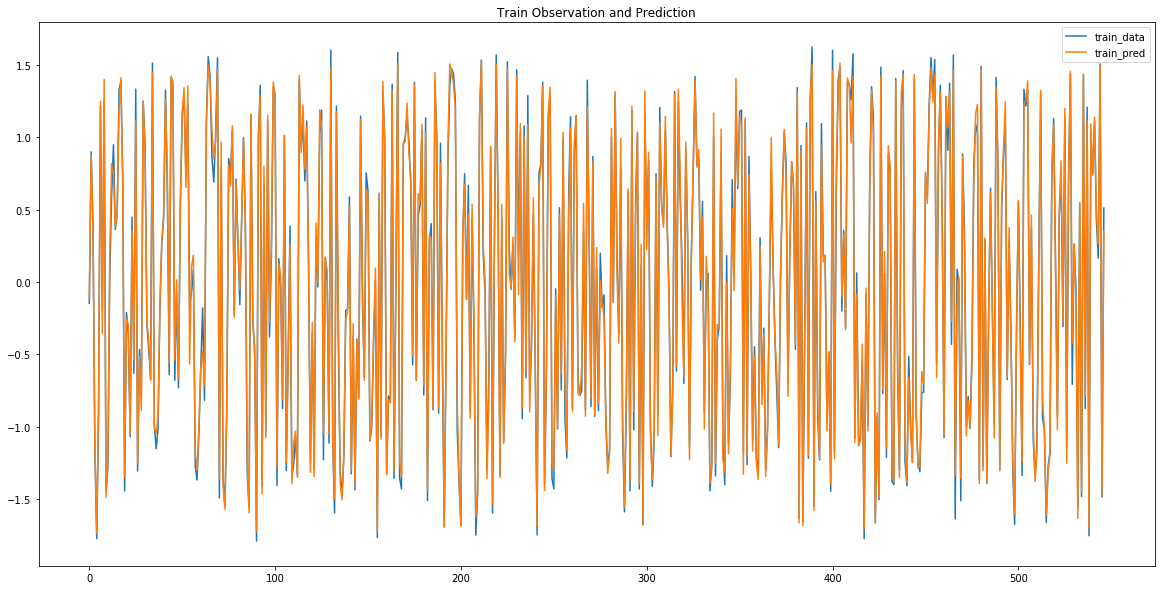

In [202]:
plt.figure(figsize=(20,10))
plt.plot(y_train[:], label='train_data')
plt.plot(train_prediction[:], label='train_pred')
plt.title('Train Observation and Prediction')
plt.legend()